## TL;DR

This takes the ideas from my previous kernel:

- Blending with Linear Regression: https://www.kaggle.com/suicaokhoailang/blending-with-linear-regression-0-688-lb

- Beating the baseline with ONE WEIRD TRICK!: https://www.kaggle.com/suicaokhoailang/beating-the-baseline-with-one-weird-trick-0-691

The trick is a bit weirder this time, here's how to reproduce:

- Training an ensemble with normal train/validation split on a different kernel or locally.

- Blend the ensemble with linear regression, take the coefficients and the optimal threshold.

- Train and commit on full dataset, no validation, use the precomputed values above.

The model is surprisingly robust, scoring 0.692 in two consecutive runs.

Again, thank **Shujian Liu** for his great contributions.

## V6
 Improve your Score with some Text Preprocessing
 省略形、missspeliingを直したら下がっちゃった
 0.690
 
 ## V7
 とりまadd_lowerだけのでやってみる
 
 ## 12/23 12:36 max feature
 95000 -> 210000でGloveする
 
 ## Blendの方法試してた
 
linearとかridgeよりも単に平均(0.6985317267237185)するほうがいい(笑)
LGBにするとちょっとだけ勝ってる(0.6988705868965321)

* https://www.kaggle.com/shujian/single-rnn-with-4-folds-clr by shujian
* https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings by SRK
* https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings by Dieter
* https://www.kaggle.com/shujian/mix-of-nn-models-based-on-meta-embedding by shujian
* https://www.kaggle.com/gmhost/gru-capsule by Puck Wang
* Based on SRK's kernel: https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings
* Vladimir Demidov's 2DCNN textClassifier: https://www.kaggle.com/yekenot/2dcnn-textclassifier
* Attention layer from Khoi Ngyuen: https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb
* LSTM model from Strideradu: https://www.kaggle.com/strideradu/word2vec-and-gensim-go-go-go
* https://www.kaggle.com/danofer/different-embeddings-with-attention-fork

In [1]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [2]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [2]:
%%time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import time

import codecs
# Any results you write to the current directory are saved as output.

['train.csv', 'embeddings', 'test.csv']
CPU times: user 195 µs, sys: 179 µs, total: 374 µs
Wall time: 11 ms


**Load packages and data**

In [3]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate, Conv1D, MaxPool1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 95000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use

In [6]:
# puncts = [ '"', ')', '(', '-', '|', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
#  '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
#  '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
#  '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
#  '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', 
# 'é', '&amp;','₹', 'á', '²', 'ế', '청', '하', '¨', '‘', '√', '\xa0', '高', '端', '大', '气', '上', '档', '次', '_', '½', 'π', '#', 
# '小', '鹿', '乱', '撞', '成', '语', 'ë', 'à', 'ç', '@', 'ü', 'č', 'ć', 'ž', 'đ', '°', 'द', 'े', 'श', '्', 'र', 'ो', 'ह', 
# 'ि', 'प', 'स', 'थ', 'त', 'न', 'व', 'ा', 'ल', 'ं', '林', '彪', '€', '\u200b', '˚', 'ö', '~', '—', '越', '人', 'च', 'म', 'क', 
# 'ु', 'य', 'ी', 'ê', 'ă', 'ễ', '∞', '抗', '日', '神', '剧', '，', '\uf02d', '–', 'ご', 'め', 'な', 'さ', 'い', 'す', 
# 'み', 'ま', 'せ', 'ん', 'ó', 'è', '£', '¡', 'ś', '≤', '¿', 'λ', '魔', '法', '师', '）', 'ğ', 'ñ', 'ř', '그', '자', '식', '멀', 
# '쩡', '다', '인', '공', '호', '흡', '데', '혀', '밀', '어', '넣', '는', '거', '보', '니', 'ǒ', 'ú', '️', 'ش', 'ه', 'ا', 'د',
# 'ة', 'ل', 'ت', 'َ', 'ع', 'م', 'ّ', 'ق', 'ِ', 'ف', 'ي', 'ب', 'ح', 'ْ', 'ث', '³', '饭', '可', '以', '吃', '话', '不', '讲', 
# '∈', 'ℝ', '爾', '汝', '文', '言', '∀', '禮', 'इ', 'ब', 'छ', 'ड', '़', 'ʒ', '有', '「', '寧', '錯', '殺', '一', '千', '絕', 
# '放', '過', '」', '之', '勢', '㏒', '㏑', 'ू', 'â', 'ω', 'ą', 'ō', '精', '杯', 'í', '生', '懸', '命', 'ਨ', 'ਾ', 'ਮ', 'ੁ', 
# '₁', '₂', 'ϵ', 'ä', 'к', 'ɾ', '\ufeff', 'ã', '©', '\x9d', 'ū', '™', '＝', 'ù', 'ɪ', 'ŋ', 'خ', 'ر', 'س', 'ن', 'ḵ', 'ā']
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, ' {punct} '.format(punct=punct))
    return x

def split_text(x):
    x = wordninja.split(x)
    return '-'.join(x)

In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text, mapping):
    """
    Parameters
    -----
        text: string
            質問
        mapping: dict
            省略形：元の単語たち
    Returns
    -----
        text: string
            省略形が直されたテキスト
    """
    # 点を統一する
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
        
    # 省略形に入ってるのは、省略されてない単語に、そうでなければそのまま
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '§': "", '©':"copyright", '®':"", '±':'plusminus', '·':" ", '»':" ", '½': 'half', '¾': "three-fourth", 'é':"e", 'ï':"i", '…':'...', '→':'->', '≤':'less'}
def clean_special_chars(text, punct, mapping):
    
    # knownに入れ替える
    for p in mapping:
        text = text.replace(p, mapping[p])
        
    # punctsの周りをわかちする
    for p in punct:
        text = text.replace(p, ' {p} '.format(p=p))
    
    # 入れ替えるのと分かちも一緒にしてる
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def build_vocab(texts):
    """
    
    Parameters
    -----
    texts: pandas.Series
        question textの列
        
    Returns
    -----
    dict: 
        単語とカウント
    
    """
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


In [8]:
def load_and_prec():
    train_df = pd.read_csv("../input/train.csv")
    test_df = pd.read_csv("../input/test.csv")
    
    train_df["question_text"] = train_df["question_text"].str.lower()
    test_df["question_text"] = test_df["question_text"].str.lower()
    
    #train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_contractions(x, contraction_mapping))
    #test_df['question_text'] = test_df['question_text'].apply(lambda x: clean_contractions(x, contraction_mapping))
    
    #train_df['question_text'] = train_df['question_text'].apply(lambda x: clean_special_chars(x, puncts, punct_mapping))
    #test_df['question_text'] = test_df['question_text'].apply(lambda x: clean_special_chars(x, puncts, punct_mapping))
    
    #train_df['question_text'] = train_df['question_text'].apply(lambda x: correct_spelling(x, mispell_dict))
    #test_df['question_text'] = test_df['question_text'].apply(lambda x: correct_spelling(x, mispell_dict))
    
    train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_text(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))
    
    print("Train shape : ",train_df.shape)
    print("Test shape : ",test_df.shape)
    
    ## split to train and val
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2018) # hahaha


    ## fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    val_X = val_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values

    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features) # 頻度順に上からmax_features子だけの単語を使う
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)

    ## Get the target values
    train_y = train_df['target'].values
    val_y = val_df['target'].values  
    
    #shuffling the data
    np.random.seed(2018)
    trn_idx = np.random.permutation(len(train_X))
    val_idx = np.random.permutation(len(val_X))

    train_X = train_X[trn_idx]
    val_X = val_X[val_idx]
    train_y = train_y[trn_idx]
    val_y = val_y[val_idx]    
    
    return train_X, val_X, test_X, train_y, val_y, tokenizer.word_index

**Load embeddings**

In [9]:

def load_glove(word_index):
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
    
def load_fasttext(word_index):    
    EMBEDDING_FILE = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    EMBEDDING_FILE = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in codecs.open(EMBEDDING_FILE, 'r', errors = 'ignore') if len(o)>100)
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.0053247833,0.49346462
    embed_size = all_embs.shape[1]
    print(emb_mean,emb_std,"para")

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

**CNN Model**

In [10]:
# https://www.kaggle.com/yekenot/2dcnn-textclassifier
def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp = Input(shape=(maxlen,)) # batch sizeを含まない
    # maxlen: 70
    # max_features: indexの数
    # embed_size: embedの次元 300 先頭できまってる
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp) # (batch, embeddim, input_length)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [11]:
# https://www.kaggle.com/yekenot/2dcnn-textclassifier
def model_cnn_1d(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp = Input(shape=(maxlen,)) # batch sizeを含まない
    # maxlen: 70
    # max_features: indexの数
    # embed_size: embedの次元 300 先頭できまってる
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp) # (batch, embeddim, input_length)
    x = Reshape((maxlen, embed_size))(x) # batch, input_length, embed_size

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv1D(num_filters, kernel_size=filter_sizes[i],
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool1D(pool_size=maxlen - filter_sizes[i] + 1)(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

**Attention layer**

In [12]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

**LSTM models**

In [13]:
def model_lstm_atten(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(maxlen)(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [14]:
def model_gru_srk_atten(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = Attention(maxlen)(x) # New
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model    
    

In [15]:
def model_lstm_du(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
def model_gru_atten_3(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(100, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = Attention(maxlen)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

**Train and predict**

In [17]:
# https://www.kaggle.com/strideradu/word2vec-and-gensim-go-go-go
def train_pred(model, epochs=2):
    for e in range(epochs):
        model.fit(train_X, train_y, batch_size=512, epochs=1, validation_data=(val_X, val_y))
    pred_train_y = model.predict([train_X], batch_size=1024, verbose=0)
    pred_val_y = model.predict([val_X], batch_size=1024, verbose=0)
    pred_test_y = model.predict([test_X], batch_size=1024, verbose=0)
    return pred_train_y, pred_val_y, pred_test_y

**Main part: load, train, pred and blend**

In [18]:
%%time
train_X, val_X, test_X, train_y, val_y, word_index = load_and_prec()

('Train shape : ', (1306122, 3))
('Test shape : ', (56370, 2))
CPU times: user 1min 23s, sys: 918 ms, total: 1min 24s
Wall time: 1min 25s


In [19]:
%%time
embedding_matrix_1 = load_glove(word_index)

CPU times: user 1min 18s, sys: 3.27 s, total: 1min 22s
Wall time: 1min 27s


In [20]:
embedding_matrix_1.shape

(95000, 300)

In [21]:
%%time
embedding_matrix_2 = load_fasttext(word_index)

CPU times: user 36.3 s, sys: 1.19 s, total: 37.5 s
Wall time: 40.2 s


In [22]:
%%time
embedding_matrix_3 = load_para(word_index)

(-0.0053247833, 0.49346462, 'para')
CPU times: user 1min 3s, sys: 1.95 s, total: 1min 5s
Wall time: 1min 9s


In [23]:
%%time
## Simple average: http://aclweb.org/anthology/N18-2031

# We have presented an argument for averaging as
# a valid meta-embedding technique, and found experimental
# performance to be close to, or in some cases 
# better than that of concatenation, with the
# additional benefit of reduced dimensionality  


## Unweighted DME in https://arxiv.org/pdf/1804.07983.pdf

# “The downside of concatenating embeddings and 
#  giving that as input to an RNN encoder, however,
#  is that the network then quickly becomes inefficient
#  as we combine more and more embeddings.”
  
embedding_matrix_5 = np.mean([embedding_matrix_1, embedding_matrix_2, embedding_matrix_3], axis = 0)
embedding_matrix_4 = np.mean([embedding_matrix_1, embedding_matrix_3], axis = 0)
np.shape(embedding_matrix_4)

CPU times: user 313 ms, sys: 176 ms, total: 489 ms
Wall time: 488 ms


In [24]:
list_embedding_matrix = [embedding_matrix_1, embedding_matrix_2, embedding_matrix_3, embedding_matrix_4, embedding_matrix_5]

In [25]:
%%time
outputs = []

pred_train_y, pred_val_y, pred_test_y = train_pred(model_cnn_1d(embedding_matrix_2), epochs = 2) # GloVe only
outputs.append([pred_train_y, pred_val_y, pred_test_y, '1d-CNN-fasttext'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 73s 70us/step - loss: 0.1143 - acc: 0.9549 - val_loss: 0.1029 - val_acc: 0.9587
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 66s 63us/step - loss: 0.0904 - acc: 0.9638 - val_loss: 0.1041 - val_acc: 0.9586
CPU times: user 1min 43s, sys: 42.1 s, total: 2min 25s
Wall time: 2min 32s


In [142]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_gru_atten_3(embedding_matrix_1), epochs = 3)
outputs[1] = [pred_train_y, pred_val_y, pred_test_y, '3-GRU-atten-glov-e3']

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 118s 113us/step - loss: 0.1140 - acc: 0.9552 - val_loss: 0.1033 - val_acc: 0.9584
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 116s 111us/step - loss: 0.1008 - acc: 0.9599 - val_loss: 0.1000 - val_acc: 0.9601
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 115s 110us/step - loss: 0.0947 - acc: 0.9623 - val_loss: 0.0981 - val_acc: 0.9608
CPU times: user 4min 25s, sys: 1min 11s, total: 5min 37s
Wall time: 6min 36s


In [143]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_gru_atten_3(embedding_matrix_3), epochs = 3)
outputs[2] = [pred_train_y, pred_val_y, pred_test_y, '3-GRU-atten-parag-3']

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 120s 115us/step - loss: 0.1162 - acc: 0.9544 - val_loss: 0.1058 - val_acc: 0.9579
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 119s 114us/step - loss: 0.1013 - acc: 0.9599 - val_loss: 0.1015 - val_acc: 0.9598
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 120s 115us/step - loss: 0.0932 - acc: 0.9628 - val_loss: 0.1022 - val_acc: 0.9600
CPU times: user 4min 33s, sys: 1min 14s, total: 5min 47s
Wall time: 6min 48s


In [28]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_du(embedding_matrix_5), epochs = 2)
outputs.append([pred_train_y, pred_val_y, pred_test_y, 'LSTM-DU-all'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 67s 64us/step - loss: 0.1131 - acc: 0.9559 - val_loss: 0.1004 - val_acc: 0.9598
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 67s 64us/step - loss: 0.0896 - acc: 0.9637 - val_loss: 0.1000 - val_acc: 0.9601
CPU times: user 1min 48s, sys: 39.4 s, total: 2min 28s
Wall time: 2min 28s


In [29]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_atten(embedding_matrix_1), epochs = 3)
outputs.append([pred_train_y, pred_val_y, pred_test_y, '2-LSTM-attention-glov'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 91s 87us/step - loss: 0.1178 - acc: 0.9538 - val_loss: 0.1037 - val_acc: 0.9585
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 90s 86us/step - loss: 0.1019 - acc: 0.9595 - val_loss: 0.1019 - val_acc: 0.9588
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 90s 86us/step - loss: 0.0954 - acc: 0.9618 - val_loss: 0.1008 - val_acc: 0.9606
CPU times: user 3min 28s, sys: 58.9 s, total: 4min 27s
Wall time: 5min 10s


In [30]:
%%time
pred_train_y, pred_val_y, pred_test_y = train_pred(model_lstm_atten(embedding_matrix_4), epochs = 3)
outputs.append([pred_train_y, pred_val_y, pred_test_y, '2-LSTM-attention-glov+parag'])

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 91s 87us/step - loss: 0.1188 - acc: 0.9541 - val_loss: 0.1067 - val_acc: 0.9570
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 90s 86us/step - loss: 0.1015 - acc: 0.9597 - val_loss: 0.1025 - val_acc: 0.9593
Train on 1044897 samples, validate on 261225 samples
Epoch 1/1
1044897/1044897 [==============================] - 91s 87us/step - loss: 0.0947 - acc: 0.9622 - val_loss: 0.0975 - val_acc: 0.9608
CPU times: user 3min 29s, sys: 59.5 s, total: 4min 28s
Wall time: 5min 10s


In [144]:
pred_train_array = np.concatenate([o[0] for o in outputs], axis=1)

In [145]:
pred_train_array.shape

(1044897, 6)

In [146]:
pred_train_pdf = pd.DataFrame(pred_train_array)

In [147]:
pred_train_pdf.head()

0         1         2         3         4         5
0  0.000283  0.000254  0.000361  0.000037  0.000247  0.000311
1  0.000370  0.000425  0.001210  0.000454  0.001219  0.001448
2  0.249168  0.355587  0.120146  0.225410  0.168079  0.667253
3  0.007673  0.000315  0.000399  0.000656  0.000574  0.001135
4  0.627751  0.821290  0.803044  0.608054  0.749295  0.706210

In [148]:
pred_val_array = np.concatenate([o[1] for o in outputs], axis=1)

In [149]:
corr = pred_train_pdf.corr()

In [150]:
%matplotlib inline

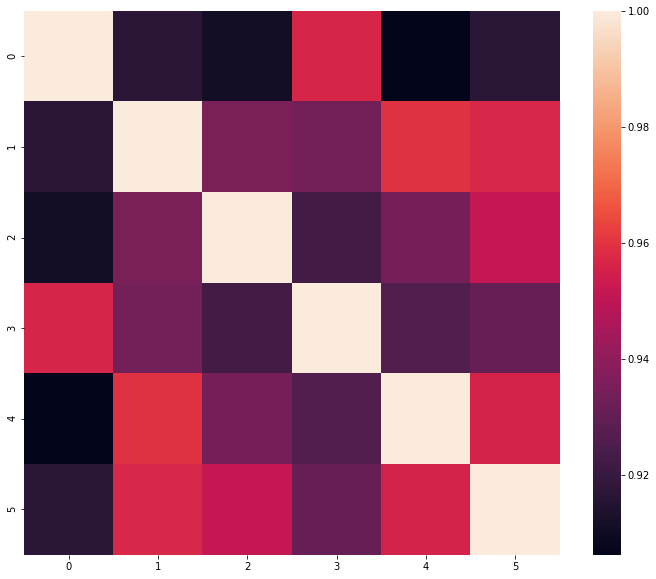

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(corr)


In [152]:
from sklearn.metrics import f1_score

## Linear Regression

In [153]:
from sklearn.linear_model import LinearRegression, Ridge

0.6643988336858956


0.3384615384615385

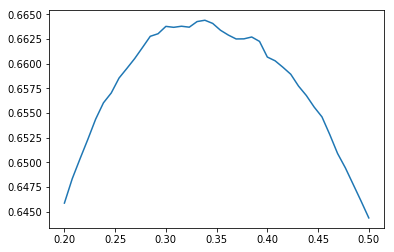

In [157]:
lr_clf = LinearRegression().fit(pred_train_array,train_y)

val_proba_y = lr_clf.predict(pred_val_array)

lr_clf.coef_

f1_list = []
for thr in np.linspace(0.2, 0.5, 40):
    f1_list.append(f1_score(val_proba_y > thr, val_y, pos_label=1))

plt.plot(np.linspace(0.2, 0.5, 40), f1_list)

print(max(f1_list))
np.linspace(0.2, 0.5, 40)[np.argmax(f1_list)]

## Ridge

0.664265706282513


0.3384615384615385

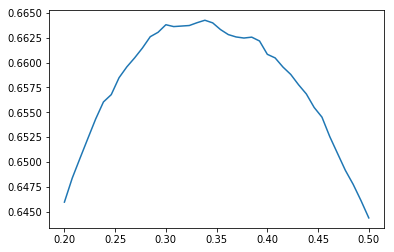

In [158]:
# Ridge
lr_clf = Ridge().fit(pred_train_array,train_y)

val_proba_y = lr_clf.predict(pred_val_array)

lr_clf.coef_

f1_list = []
for thr in np.linspace(0.2, 0.5, 40):
    f1_list.append(f1_score(val_proba_y > thr, val_y, pos_label=1))

plt.plot(np.linspace(0.2, 0.5, 40), f1_list)

print(max(f1_list))
np.linspace(0.2, 0.5, 40)[np.argmax(f1_list)]

In [159]:
pred_val_array.shape

(261225, 6)

6

0.6657290729072908
0.6875294394724447
0.6744871492572506
0.6761391195183886
0.6836038309342204
0.6834307540945657


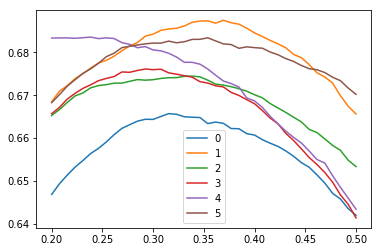

In [166]:
for i, val_proba_y in enumerate([o[1] for o in outputs]):
    f1_list = []
    for thr in np.linspace(0.2, 0.5, 40):
        f1_list.append(f1_score(val_proba_y > thr, val_y, pos_label=1))

    plt.plot(np.linspace(0.2, 0.5, 40), f1_list, label=i)

    print(max(f1_list))
    np.linspace(0.2, 0.5, 40)[np.argmax(f1_list)]
plt.legend()

## ただの平均

0.6995329527763362


0.3153846153846154

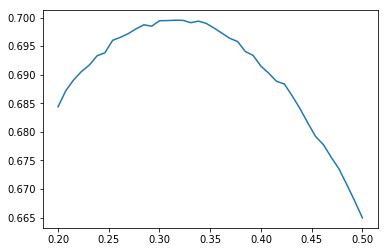

In [167]:
val_proba_y = pred_val_array.mean(axis=1)
lr_clf.coef_

f1_list = []
for thr in np.linspace(0.2, 0.5, 40):
    f1_list.append(f1_score(val_proba_y > thr, val_y, pos_label=1))

plt.plot(np.linspace(0.2, 0.5, 40), f1_list)

print(max(f1_list))
np.linspace(0.2, 0.5, 40)[np.argmax(f1_list)]

# LightGBM

In [58]:
import numpy as np


class UniformSampler:
    def __init__(self, start, end, dtype=float):
        self.start = start
        self.end = end
        self.dtype = dtype

    def rvs(self, random_state=None):
        return self.dtype(np.random.uniform(self.start, self.end))


class LogUniformSampler:
    def __init__(self, start, end, dtype=float):
        self.start = start
        self.end = end
        self.dtype = dtype

    def rvs(self, random_state=None):
        return self.dtype(10**np.random.uniform(self.start, self.end))


In [60]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

(0, 'Sun Dec 23 05:37:37 2018')
(10, 'Sun Dec 23 05:39:35 2018')
(20, 'Sun Dec 23 05:41:28 2018')
(30, 'Sun Dec 23 05:43:40 2018')
(40, 'Sun Dec 23 05:46:14 2018')
(50, 'Sun Dec 23 05:48:19 2018')
(60, 'Sun Dec 23 05:51:27 2018')
(70, 'Sun Dec 23 05:53:55 2018')
(80, 'Sun Dec 23 05:56:15 2018')
(90, 'Sun Dec 23 05:59:12 2018')
0.09523738737138336
{'num_leaves': 82, 'reg_alpha': 0.005969964466279155, 'n_jobs': -1, 'colsample_bytree': 0.19806699623399943, 'max_depth': 2, 'learning_rate': 0.002563229225896524, 'min_child_weight': 0.0008435466112663996, 'min_split_gain': 9.120063436997499e-05, 'n_estimators': 1409, 'subsample': 0.3863875317892158, 'reg_lambda': 0.0669438158925457, 'random_state': 1999, 'silent': True, 'objective': 'binary', 'min_child_samples': 3, 'boosting_type': 'gbdt'}
1409
0.9619025744090344


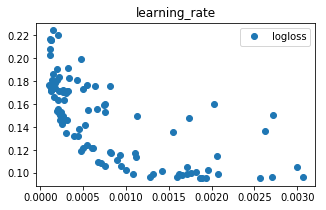

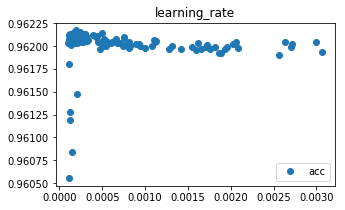

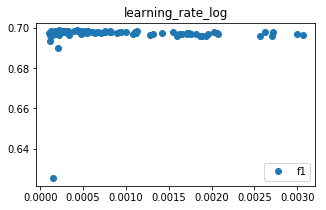

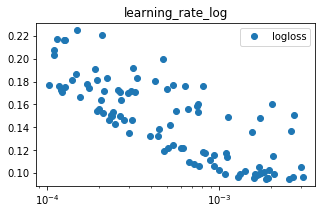

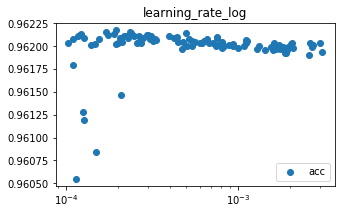

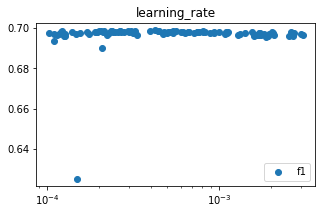

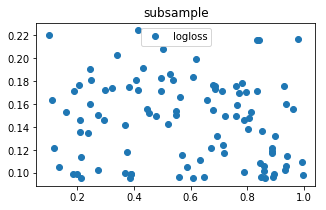

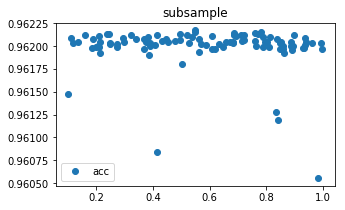

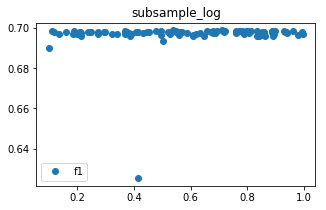

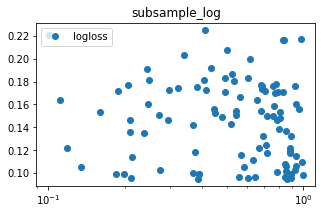

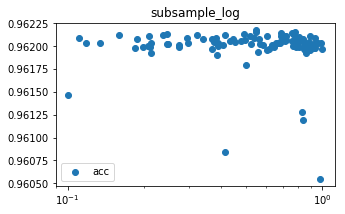

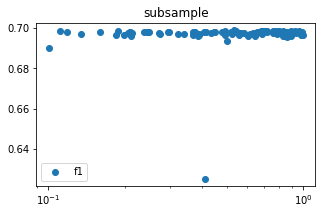

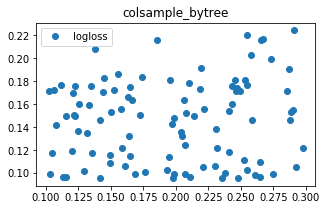

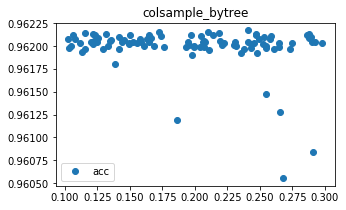

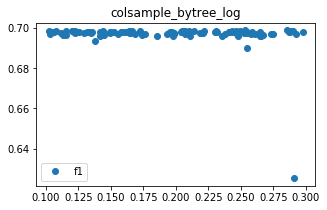

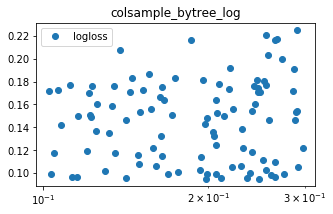

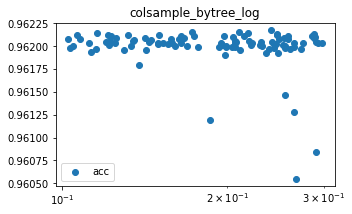

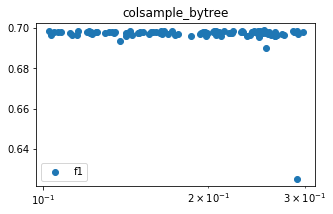

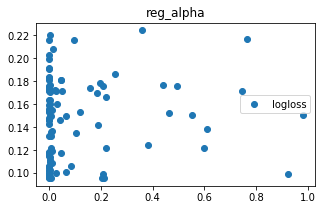

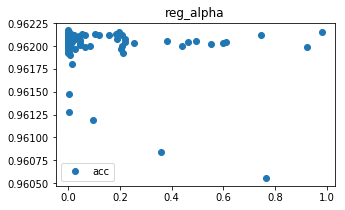

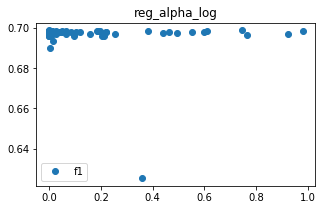

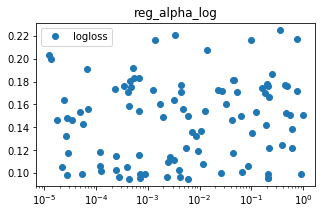

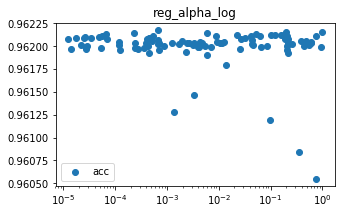

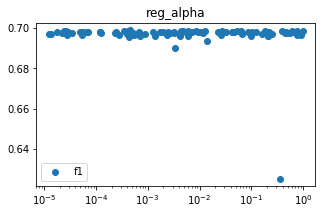

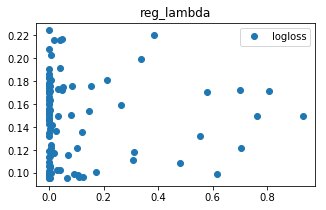

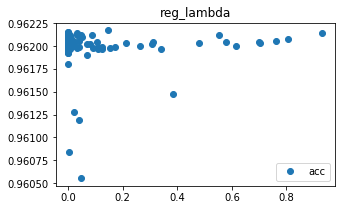

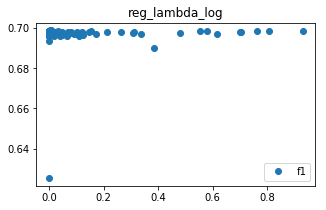

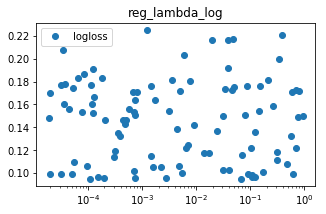

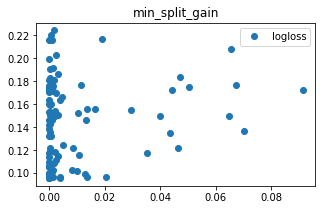

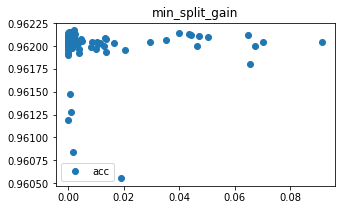

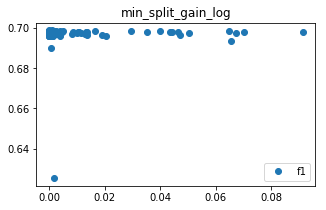

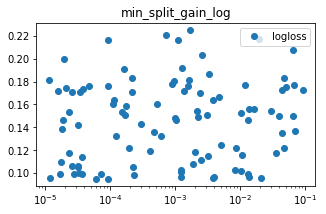

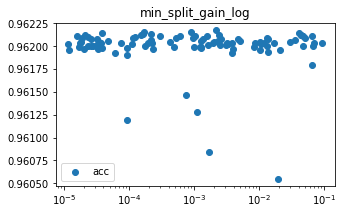

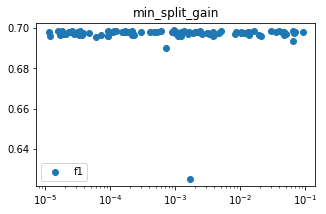

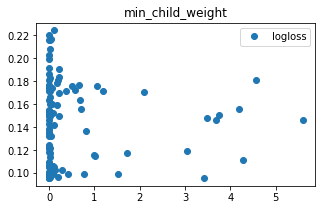

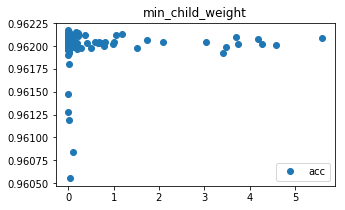

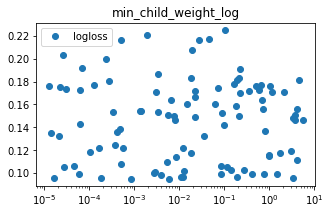

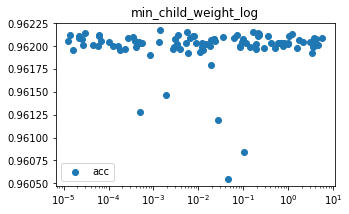

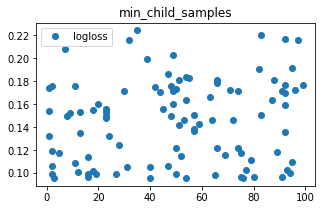

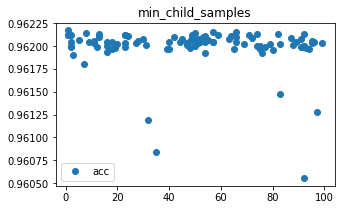

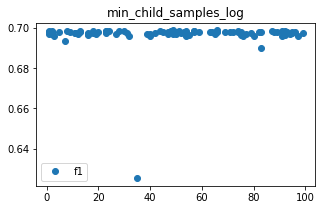

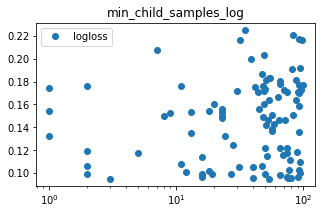

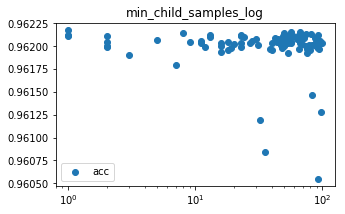

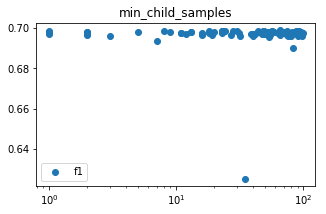

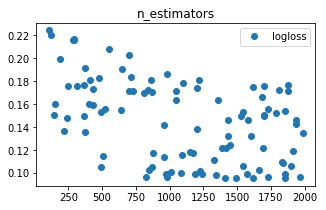

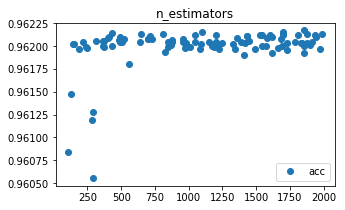

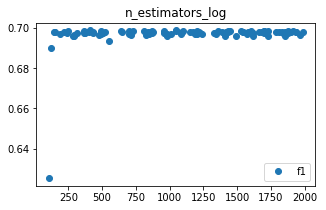

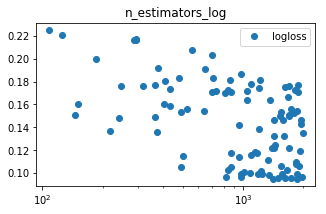

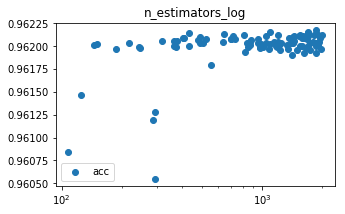

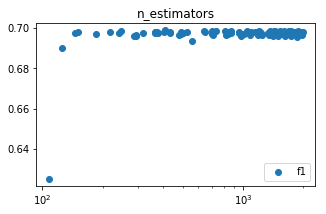

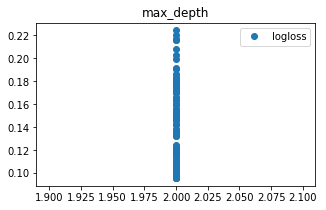

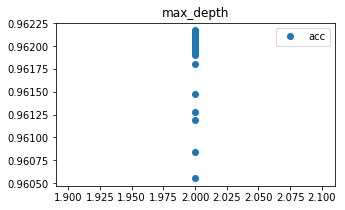

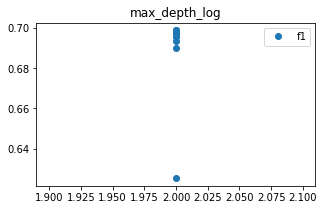

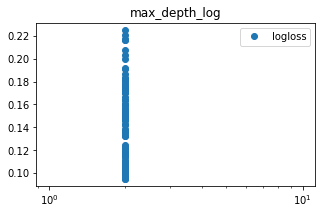

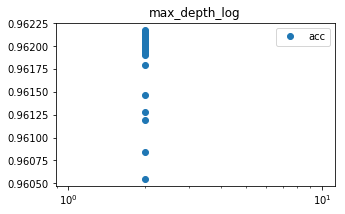

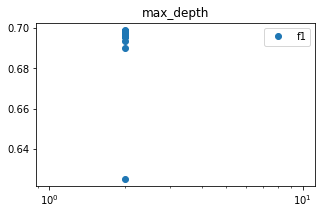

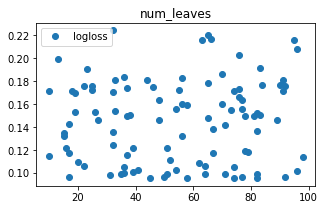

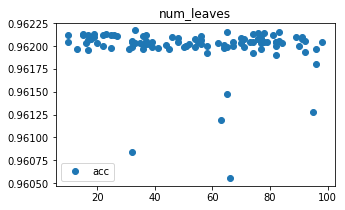

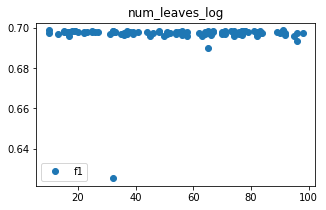

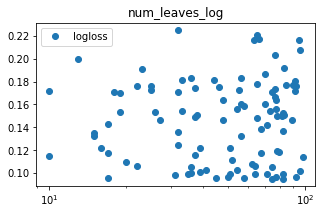

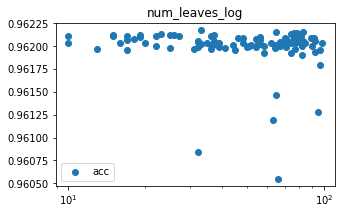

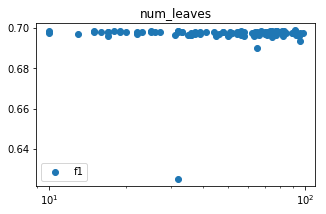

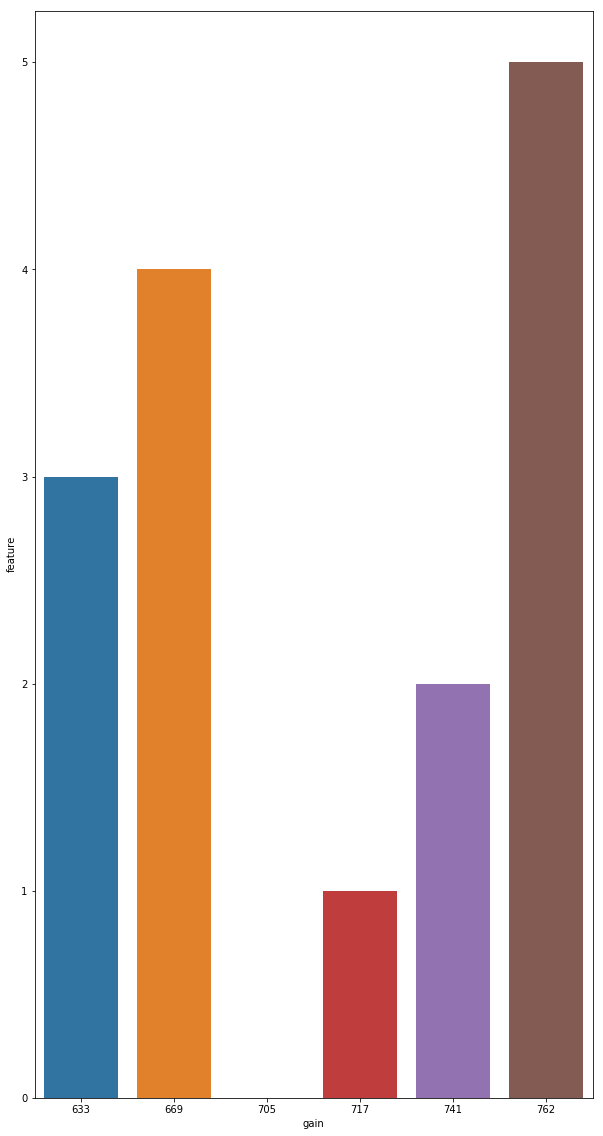

In [114]:
param_samplers = {
    'learning_rate': LogUniformSampler(-3.2, -2.5),
    'subsample': UniformSampler(0.1, 1),
    'colsample_bytree': UniformSampler(0.1, 0.3),
    'reg_alpha': LogUniformSampler(-5, 0),
    'reg_lambda': LogUniformSampler(-5, 0),
    'min_split_gain': LogUniformSampler(-5, -1),
    'min_child_weight': LogUniformSampler(-5, 1),
    'min_child_samples': UniformSampler(1, 100, int),
    'n_estimators': UniformSampler(1000, 5000, int),
    'max_depth': UniformSampler(2, 3, int),
    'num_leaves': UniformSampler(10, 100, int),
}
 
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
param_list = []
best_iteration_list = []
score_list = []
max_acc_list = []
argmax_acc_list = []
max_f1_list = []
argmax_f1_list = []
n_seed = 100
for i_seed in range(n_seed):
    if i_seed % 10 == 0:
        print(i_seed, time.ctime())
    gal_clfs = []
    gal_importances = pd.DataFrame()
    gal_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': param_samplers['learning_rate'].rvs(),
        'subsample': param_samplers['subsample'].rvs(),
        'colsample_bytree': param_samplers['colsample_bytree'].rvs(),
        'reg_alpha': param_samplers['reg_alpha'].rvs(),
        'reg_lambda': param_samplers['reg_lambda'].rvs(),
        'min_split_gain': param_samplers['min_split_gain'].rvs(),
        'min_child_weight': param_samplers['min_child_weight'].rvs(),
        'min_child_samples': param_samplers['min_child_samples'].rvs(),
        'n_estimators': param_samplers['n_estimators'].rvs(),
        'max_depth': param_samplers['max_depth'].rvs(),
        'num_leaves': param_samplers['num_leaves'].rvs(),
        'silent': True,
        'n_jobs': -1,
        'random_state':1999
    }
    
    param_list.append(gal_lgb_params)
    
    gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
    gal_clf.fit(
        pred_train_array, train_y,
        eval_set=[(pred_val_array, val_y)],
        verbose=False,
        early_stopping_rounds=50
    )

    imp_df = pd.DataFrame()
    imp_df['feature'] = range(len(gal_clf.feature_importances_))
    imp_df['gain'] = gal_clf.feature_importances_
    gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)

    gal_clfs.append(gal_clf)

    score_list.append(np.mean(gal_clf.best_score_['valid_0']['binary_logloss']))
    best_iteration_list.append(gal_clf.best_iteration_)
    
    gal_val_y = gal_clf.predict_proba(pred_val_array)
    acc_list = []
    f1_list = []
    for thr in np.linspace(0, 1, 100):
        f1_list.append(f1_score(gal_val_y[:, 1] > thr, val_y, pos_label=1))
        acc_list.append(np.equal(gal_val_y[:, 1] > thr, val_y).mean())
    
    max_acc_list.append(max(acc_list))
    argmax_acc_list.append(np.argmax(acc_list))
    max_f1_list.append(max(f1_list))
    argmax_f1_list.append(np.argmax(f1_list))


param_keys = ['learning_rate',
  'subsample',
  'colsample_bytree',
  'reg_alpha',
  'reg_lambda',
  'min_split_gain',
  'min_child_weight',
  'min_child_samples',
  'n_estimators',
  'max_depth',
  'num_leaves']

for param_key in param_keys:
    values = [ param_dict[param_key] for param_dict in param_list]
    plt.figure(figsize=(5, 3))
    plt.title(param_key)
    plt.plot(values, score_list, 'o', label='logloss')
    plt.legend()
    
    plt.figure(figsize=(5, 3))
    plt.title(param_key)
    plt.plot(values, max_acc_list, 'o', label='acc')
    plt.legend()
    
    plt.figure(figsize=(5, 3))
    plt.title(param_key)
    plt.plot(values, max_f1_list, 'o', label='f1')
    plt.legend()
    
    plt.title(param_key+'_log')
    plt.figure(figsize=(5, 3))
    plt.title(param_key)
    plt.xscale('log')
    plt.plot(values, score_list, 'o', label='logloss')
    plt.legend()
    
    plt.title(param_key+'_log')
    plt.figure(figsize=(5, 3))
    plt.title(param_key)
    plt.plot(values, max_acc_list, 'o', label='acc')
    plt.xscale('log')
    plt.legend()
    
    plt.title(param_key+'_log')
    plt.figure(figsize=(5, 3))
    plt.title(param_key)
    plt.plot(values, max_f1_list, 'o', label='f1')
    plt.xscale('log')
    plt.legend()
    
best_id = np.argmin(max_f1_list)
print(score_list[best_id])
print(param_list[best_id])
print(best_iteration_list[best_id])
print('max-acc', max(acc_list)))
print('max-f1', max(max_f1_list))

In [118]:
max(max_f1_list)

0.6988705868965321

In [70]:
best_id = np.argmax(acc_list)
print(score_list[best_id])
print(param_list[best_id])
print(best_iteration_list[best_id])
print(max(acc_list))

0.09910717782503008
{'num_leaves': 51, 'reg_alpha': 3.326660068467803e-05, 'n_jobs': -1, 'colsample_bytree': 0.17373793156554096, 'max_depth': 2, 'learning_rate': 0.0021940908012303166, 'min_child_weight': 1.1538936388845917, 'min_split_gain': 0.018550689546267696, 'n_estimators': 936, 'subsample': 0.9615074764481151, 'reg_lambda': 0.05079384889056895, 'random_state': 1999, 'silent': True, 'objective': 'binary', 'min_child_samples': 97, 'boosting_type': 'gbdt'}
936
0.9619599961718824


In [75]:
%%time
gal_importances = pd.DataFrame()
gal_lgb_params = {'num_leaves': 51, 'reg_alpha': 3e-05, 'n_jobs': -1, 'colsample_bytree': 0.3, 'max_depth': 2, 'learning_rate': 0.002, 'min_child_weight': 1.2, 'min_split_gain': 0.02, 'n_estimators': 1000, 'subsample': 0.95, 'reg_lambda': 0.05, 'random_state': 1999, 'silent': True, 'objective': 'binary', 'min_child_samples': 100, 'boosting_type': 'gbdt'}
param_list.append(gal_lgb_params)

gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
gal_clf.fit(
    pred_train_array, train_y,
    eval_set=[(pred_val_array, val_y)],
    verbose=100,
    early_stopping_rounds=50
)

lgb_pred_val_y = gal_clf.predict(pred_val_array)

imp_df = pd.DataFrame()
imp_df['feature'] = range(len(gal_clf.feature_importances_))
imp_df['gain'] = gal_clf.feature_importances_
gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)
print(np.equal(lgb_pred_val_y, val_y).mean(),
      gal_clf.best_iteration_, np.mean(gal_clf.best_score_['valid_0']['binary_logloss']))


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's binary_logloss: 0.175605
[200]	valid_0's binary_logloss: 0.150182
[300]	valid_0's binary_logloss: 0.134504
[400]	valid_0's binary_logloss: 0.123899
[500]	valid_0's binary_logloss: 0.116258
[600]	valid_0's binary_logloss: 0.110665
[700]	valid_0's binary_logloss: 0.106584
[800]	valid_0's binary_logloss: 0.103495
[900]	valid_0's binary_logloss: 0.101201
[1000]	valid_0's binary_logloss: 0.0994901
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.0994901
(0.9618987462915112, 1000, 0.09949005035577899)
CPU times: user 2min 25s, sys: 0 ns, total: 2min 25s
Wall time: 12.7 s


In [76]:
gal_val_y = gal_clf.predict_proba(pred_val_array)

In [77]:
acc_list = []
for thr in np.linspace(0, 1, 100):
    acc_list.append(np.equal(gal_val_y[:, 1] > thr, val_y).mean())

In [78]:
max(acc_list)

0.9619753086419753

In [81]:
np.argmax(acc_list)

47

In [71]:
plt.plot(acc_list, score_list, 'o')

In [69]:
gal_importances.groupby('feature').gain.mean().sort_values(ascending=False)

feature
5    423
2    372
0    360
1    339
4    333
3    303
Name: gain, dtype: int64

0.696668712683444


0.25252525252525254

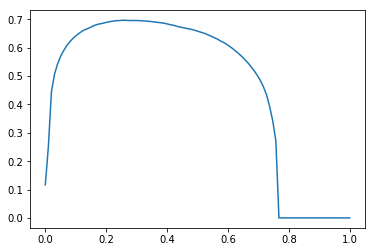

In [94]:
f1_list = []
for thr in np.linspace(0, 1, 100):
    f1_list.append(f1_score(gal_val_y[:, 1] > thr, val_y, pos_label=1))

plt.plot(np.linspace(0, 1, 100), f1_list)

print(max(f1_list))
np.linspace(0, 1, 100)[np.argmax(f1_list)]

In [ ]:
gal_val_y = gal_clf.predict_proba(pred_val_array)

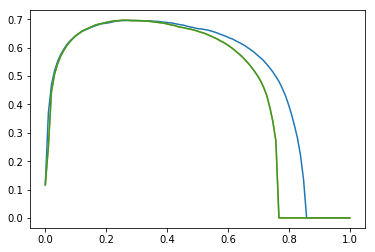

In [97]:
max_f1_list = []
argmax_f1_list = []
for a_gal_clf in gal_clfs:
    gal_val_y = a_gal_clf.predict_proba(pred_val_array)
    f1_list = []
    for thr in np.linspace(0, 1, 100):
        f1_list.append(f1_score(gal_val_y[:, 1] > thr, val_y, pos_label=1))

    plt.plot(np.linspace(0, 1, 100), f1_list)

    max_f1_list.append(max(f1_list))
    argmax_f1_list.append(np.argmax(f1_list))

In [98]:
max(max_f1_list)

0.696668712683444

In [99]:
max_f1_list

[0.6965606094555231, 0.696668712683444, 0.696668712683444]

In [100]:
gal_clfs

[LGBMClassifier(boosting_type='gbdt', class_weight=None,
         colsample_bytree=0.113753657069, importance_type='split',
         learning_rate=0.00412374491771, max_depth=2, min_child_samples=35,
         min_child_weight=0.000107039723749,
         min_split_gain=1.59191930685e-05, n_estimators=710, n_jobs=-1,
         num_leaves=29, objective='binary', random_state=1999,
         reg_alpha=1.33482575586e-05, reg_lambda=0.297540184724,
         silent=True, subsample=0.999091576368, subsample_for_bin=200000,
         subsample_freq=0),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
         importance_type='split', learning_rate=0.002, max_depth=2,
         min_child_samples=100, min_child_weight=1.2, min_split_gain=0.02,
         n_estimators=1000, n_jobs=-1, num_leaves=51, objective='binary',
         random_state=1999, reg_alpha=3e-05, reg_lambda=0.05, silent=True,
         subsample=0.95, subsample_for_bin=200000, subsample_freq=0),
 LGBMClassif

In [140]:
np.save('../mydata/1d-CNN-fasttext,3-GRU-atten-glov-e2,3-GRU-atten-parag-e2,LSTM-DU-all,2-LSTM-attention-glov,2-LSTM-attention-glov+parag-train.npy', pred_train_array)



np.save('../mydata/1d-CNN-fasttext,3-GRU-atten-glov-e2,3-GRU-atten-parag-e2,LSTM-DU-all,2-LSTM-attention-glov,2-LSTM-attention-glov+parag-val.npy', pred_val_array)